<a href="https://colab.research.google.com/github/drtophop/CASAML-Thesis/blob/main/CAS_AML_Seg_HopV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAS AML Thesis

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Content
- Setup Module and Libraries:  containing neural network-related classes and functions
    - Setup Environemt for Jupyter Notebook and Google Colab
    - Set Up PyTorch Project
- Images Dataset
- Augmentation an Importing Dataset
- Define Networks and Training for Segmentation Classification
    - Basic Network
    - Deeper Network
    - Unet Unet
- Summary

## Setup Modules and Libraries

#### Setup Environemt for Jupyter Notebook and Google Colab

In [15]:
from IPython.display import HTML, display, Image

# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"


import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/MLCV/main/notebooks/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)




Mounted at /gdrive


In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Set Up PyTorch Project

#### 1. Numpy

In [ ]:
import numpy as np

The Numpy library: Numerical computation

#### 2. PyTorch

In [ ]:
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.functional import F
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.metrics import jaccard_score

print(torch.cuda.is_available())

True


Libraries
- `torch`: Open Source Library for Machine Learning
- `pytorch_lightning as pl`: Lightweight PyTorch Wrapper for training and organizing DL models

Modules
- `nn`:  containing neural network-related classes and functions
- `Dataset, DataLoader`: for handling datasets
- `random_split`: splitting datasets into train/validation/test sets
- `F`: functional operations like activation functions
- `transforms `: data transformations, often used for image preprocessing
- `TensorBoardLogger from pytorch_lightning.loggers`: logger for recording training logs and metrics 
- `jaccard_score from sklearn.metrics`: calculating the Jaccard similarity coefficient (also known as the Intersection over Union) for evaluating model performance
 

#### 3. Handling Images and File Path

In [18]:
import os
import skimage.io
import matplotlib.pyplot as plt
import imageio.v3 as iio

from PIL import Image
from pathlib import Path

import shutil

Libraries
- `os`: interact with the operating system, like creating, deleting, and renaming files, as well as navigating directories
- `skimage.io`: scikit-image, is a library for image processing with submodule *io* for reading an image from a file, saving an image, and converting between different image representations
- `matplotlib.pyplot as plt`:  popular plotting and visualization library,with submodule pyplot as interface
- `imageio.v3 as iio`:  library for reading and writing a wide range of image data, with *iio* to access and use the functions and methods

Modules
- `Image from PIL`: Library, provides functionality for opening, manipulating, and saving different image file formats and *Image* module for  operations like resizing, cropping, and applying filters, and convert between different image formats
- `Path from pathlib`: module provides classes and methods for working with file paths and directories, with *Path* providing operations like joining paths, checking existence, and retrieving file information.

## Images Dataset

In [19]:
path_main = os.getcwd()

In [20]:
dirs_to_delete = ['carvana-image-masking-png']

for dir_to_delete in dirs_to_delete:
    path_del = os.path.join(path_main, dir_to_delete)
    if os.path.exists(path_del):
        shutil.rmtree(path_del)

#files_to_delete = ['data.yaml','yolov5m6.pt']
#
#for file_to_delete in files_to_delete:
#    file_del = os.path.join(path_main, file_to_delete)
#    if os.path.exists(file_del):
#        os.remove(file_del)

In [21]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/ipythonx/carvana-image-masking-png/download?datasetVersionNumber=1')



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: drtophop
Your Kaggle Key: ··········


100%|██████████| 828M/828M [00:56<00:00, 15.3MB/s]


In [23]:
im_path = f'{path_main}/carvana-image-masking-png/train_images'
lab_path = f'{path_main}/carvana-image-masking-png/train_masks'


print(f'does im exist: {os.path.exists(im_path)}')
print(f'does lab_path exist: {os.path.exists(lab_path)}')



does im exist: True
does lab_path exist: True


In [24]:


images_path = datapath.joinpath(im_path)
labels_path = datapath.joinpath(lab_path)

In [25]:
images_files = os.listdir(images_path)
images_files_sorted = sorted(images_files)

In [26]:
# iterate over the sorted list and rename each file with an index-based name
for i, file in enumerate(images_files_sorted):
    # generate the new name with an index based on the current position in the sorted list
    new_name = f"image_{i}.jpg"
    # use the os.rename() function to rename the file
    os.rename(os.path.join(images_path, file), os.path.join(images_path, new_name))

In [27]:
labels_files = os.listdir(labels_path)
labels_files_sorted = sorted(labels_files)

In [28]:
# iterate over the sorted list and rename each file with an index-based name
for i, file in enumerate(labels_files_sorted):
    # generate the new name with an index based on the current position in the sorted list
    new_name = f"label_{i}.jpg"
    # use the os.rename() function to rename the file
    os.rename(os.path.join(labels_path, file), os.path.join(labels_path, new_name))

This lines construcs the path to the directories containing the training images and labels for the training images

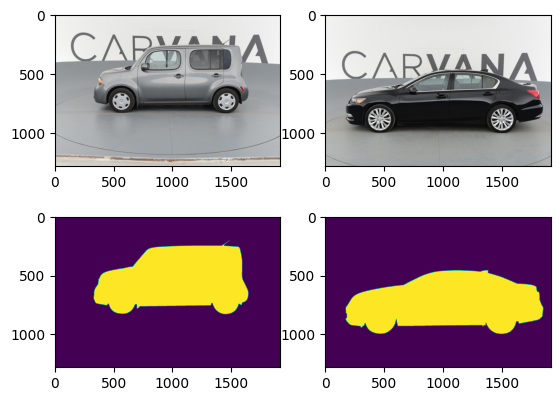

In [29]:
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(skimage.io.imread(images_path.joinpath('image_20.jpg')))
ax[0,1].imshow(skimage.io.imread(images_path.joinpath('image_4.jpg')))
ax[1,0].imshow(skimage.io.imread(labels_path.joinpath('label_20.jpg')))
ax[1,1].imshow(skimage.io.imread(labels_path.joinpath('label_4.jpg')))


The [Carvana Dataset](https://www.kaggle.com/competitions/carvana-image-masking-challenge/overview/description), provided for the competition consisted of 8,025 training images, each with a corresponding manually segmented mask indicating the car pixels. The challenge was to train a model that could accurately generate the car segmentation masks for a separate test set of images


The IoU metric was used to evaluate how well the predicted masks aligned with the ground truth masks.  the Intersection over Union (IoU)metric also known as the Jaccard Index, for binary segmentation masks



In [30]:
im_train = iio.imread(images_path.joinpath('image_20.jpg'))
im_label = iio.imread(labels_path.joinpath('label_20.jpg'))
print(type(im_train))
print(type(im_label))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Histogram of Label Image')

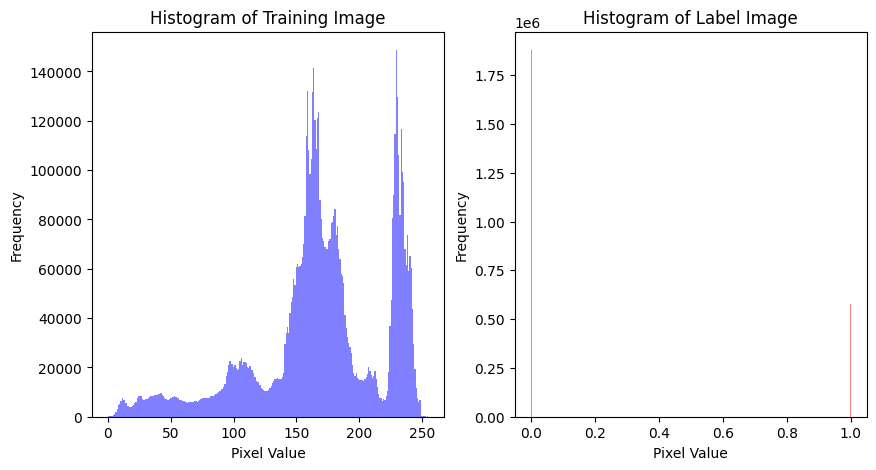

In [31]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

# Plot the histogram of the training image
ax[0].hist(im_train.flatten(), bins=256, color='b', alpha=0.5)
ax[0].set_xlabel('Pixel Value')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Training Image')

# Plot the histogram of the label image
ax[1].hist(im_label.flatten(), bins=256, color='r', alpha=0.5)
ax[1].set_xlabel('Pixel Value')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Label Image')


plt.hist() is used to compute and display the histograms of the image arrays. The flatten() function is applied to the image arrays to convert them into 1D arrays, as plt.hist() expects 1D input.

The bins parameter specifies the number of bins to use in the histogram. In this example, we use 256 bins, which is a common choice for images with 8-bit pixel values.

In [32]:
print("The resolution of Training Image is", im_train.shape, "and data type is", im_train.dtype, "since Pixel Values are from 0 to 255")

The resolution of Training Image is (1280, 1918, 3) and data type is uint8 since Pixel Values are from 0 to 255


## Augmentation an Importing Dataset

In [33]:
import warnings
warnings.filterwarnings("ignore")


image_height = 160 #1280 #160 #640
image_width = 240 #1918 #240 #960


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_height,image_width), antialias=True)])


- `transforms.Compose()`: defines transformation pipeline out of the torchvision.transforms module
- `transforms.ToTensor()`: transformation converts the input image from a PIL.Image or numpy.ndarray format to a torch.Tensor format. This allows the image to be processed by PyTorch models.
-  `transforms.Resize()`: transformation resizes the image to the specified dimensions *(image_height, image_width)*.

In [34]:
class Segdata(Dataset):
    def __init__(self, im_path, label_path, transforms=None):
        super(Segdata, self).__init__()
        self.im_path = im_path
        self.label_path = label_path
        self.transform = transforms
        self.images = os.listdir(im_path)
        self.labels = os.listdir(label_path)
        
    def __getitem__(self, index):
        
        #image_path = os.path.join(self.im_path, self.images[index])
        #x = np.array(Image.open(image_path).convert("RGB"))

        #label_path = os.path.join(self.label_path, self.labels[index])
        
        #y = np.array(Image.open(label_path).convert("L"), dtype=np.float32)

        #x = skimage.io.imread(self.im_path.joinpath(f'image_{index}.jpg'))
        #y = skimage.io.imread(self.label_path.joinpath(f'label_{index}.jpg'))

        image_path = self.im_path.joinpath(f'image_{index}.jpg')
        x = np.array(Image.open(image_path).convert("RGB"))

        label_path = self.label_path.joinpath(f'label_{index}.jpg')
        y = np.array(Image.open(label_path).convert("L"))


        y[y == 255.0] = 1.0
        
        if self.transform is not None:          
            
            x = self.transform(x)
            y = self.transform(y)
  
        return x, y

    def __len__(self):
        return len(self.images)

Segdata class provides a convenient way to load and process image and label pairs for semantic segmentation tasks.  The image is loaded using Image.open() and converted to a NumPy array of shape (height, width, channels) with RGB color space. The label is loaded similarly but converted to a single-channel grayscale image with float32 data type. Any pixel with a value of 255.0 is converted to 1.0, assuming it represents the foreground class.

In [35]:
segdata = Segdata(images_path, labels_path, transform)
train_size = int(0.8 * len(segdata))
valid_size = len(segdata)-train_size

batch_size = 16

train_data, valid_data = random_split(segdata, [train_size, valid_size])


train_loader = DataLoader(train_data, batch_size=batch_size)
validation_loader = DataLoader(valid_data, batch_size=batch_size)

Segdata dataset object, splits it into training and validation sets using random_split, and creates data loaders for the training and validation sets using DataLoader. By splitting the dataset into training and validation sets and creating data loaders, you can iterate over the data in batches during the training and validation processes.

#### lets verify Dataest Object

In [36]:
image_test, label_test = segdata[1]

Text(0.5, 1.0, 'Histogram of Label Image')

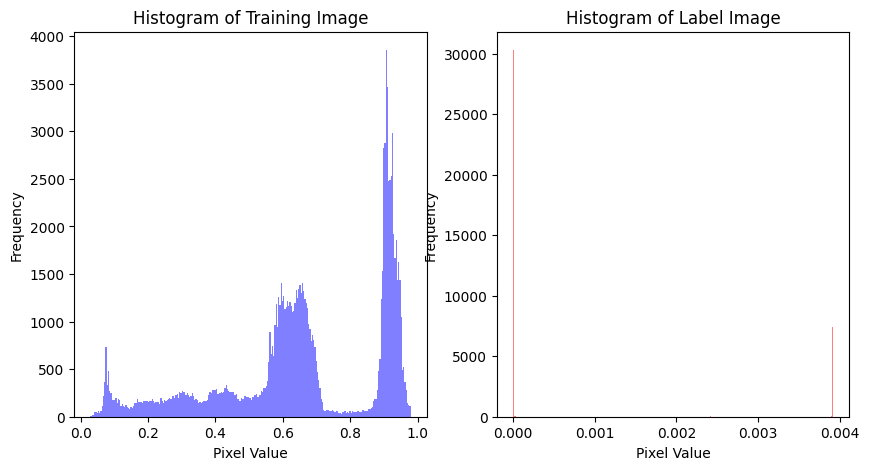

In [37]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

# Plot the histogram of the training image
ax[0].hist(image_test.flatten(), bins=256, color='b', alpha=0.5)
ax[0].set_xlabel('Pixel Value')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Training Image')

# Plot the histogram of the label image
ax[1].hist(label_test .flatten(), bins=256, color='r', alpha=0.5)
ax[1].set_xlabel('Pixel Value')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Label Image')

In [38]:
print(image_test.shape)
print(label_test.shape)

torch.Size([3, 160, 240])
torch.Size([1, 160, 240])


In [39]:
print(image_test.permute(1, 2, 0).shape)
print(label_test.permute(1, 2, 0).shape)

torch.Size([160, 240, 3])
torch.Size([160, 240, 1])


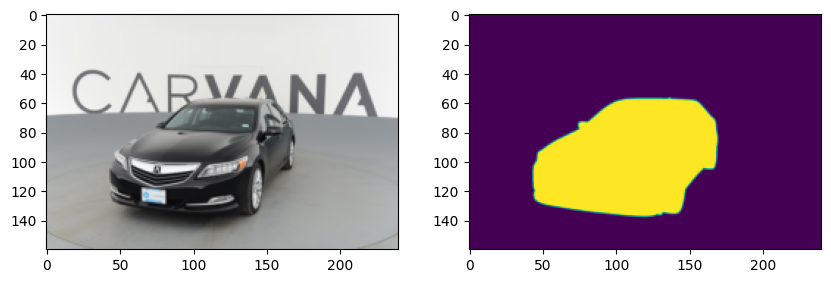

In [40]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].imshow(image_test.permute(1, 2, 0))
ax[1].imshow(label_test.permute(1, 2, 0))

#### lets verify Trainloader and Batch

In [41]:
train_loader

In [42]:
im_batch, lab_batch = next(iter(train_loader))

iteration to fetch a batch of data from the validation_loader. The iter() function is used to create an iterator from the validation_loader, and then the next() function is called on the iterator to fetch a single batch of data.

In [43]:
print(im_batch.shape)
print(lab_batch.shape)

torch.Size([16, 3, 160, 240])
torch.Size([16, 1, 160, 240])


Text(0.5, 1.0, 'Histogram of Label Image')

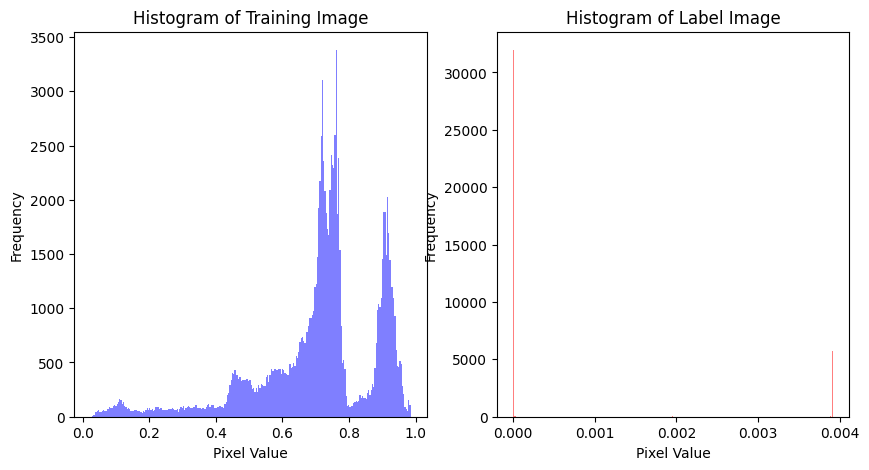

In [44]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

# Plot the histogram of the training image
ax[0].hist(im_batch[1,:,:,:].flatten(), bins=256, color='b', alpha=0.5)
ax[0].set_xlabel('Pixel Value')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Training Image')

# Plot the histogram of the label image
ax[1].hist(lab_batch[1,:,:,:].flatten(), bins=256, color='r', alpha=0.5)
ax[1].set_xlabel('Pixel Value')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Label Image')

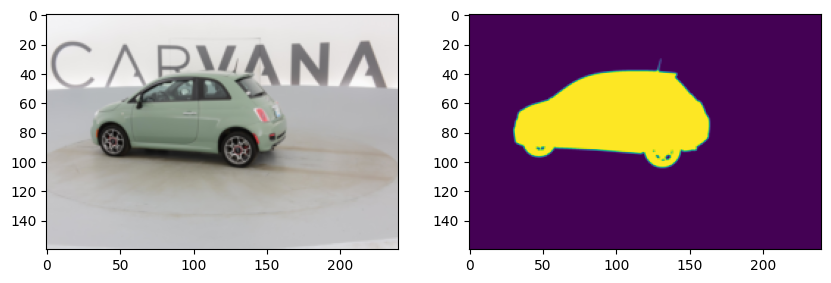

In [45]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].imshow(im_batch[1,:,:,:].permute(1, 2, 0))
ax[1].imshow(lab_batch[1,:,:,:].permute(1, 2, 0))

## Define Networks and Training for Segmentation Classification

### Unet

In [46]:
#from IPython.display import Image2
#Image2(url='https://github.com/guiwitz/DLImaging/raw/master/illustrations/unet.jpg', width=800)

#### Definiton

In [47]:
def dice_loss(output, target):
    smooth = 1e-8  # smoothing factor to avoid division by zero
    output = output.view(-1)
    target = target.view(-1)
    
    intersection = torch.sum(output * target)
    union = torch.sum(output) + torch.sum(target)
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    loss = 1.0 - dice
    
    return loss


In [48]:
class Unet(pl.LightningModule):
    def __init__(self, learning_rate):
        super(Unet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.transpose_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, padding=0, stride=2)
        self.conv2_t = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.transpose_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, padding=0, stride=2)
        self.conv1_t = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv_final = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)

        #self.loss = nn.BCEWithLogitsLoss()
        self.loss = dice_loss
        
        self.learning_rate = learning_rate

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x = self.maxpool1(x1)
        x2 = F.relu(self.conv2(x))
        x = self.maxpool2(x2)
        x3 = F.relu(self.conv3(x))
        x2_t = self.transpose_conv3(x3)
        x = torch.cat((x2, x2_t), dim=1)
        x = F.relu(self.conv2_t(x))
        x = self.transpose_conv2(x)
        x = torch.cat((x1, x), dim=1)
        x = F.relu(self.conv1_t(x))
        x = self.conv_final(x)

        return x.sigmoid()

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = self.loss(output, y)

        self.log("Loss/Train", loss, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        
        
        x, y = batch
        output = self(x)
        output_binary = (output > 0.5).float()

        
        #Jaquard Score
        output_prob = torch.softmax(output, dim=1)
        #output_prob = torch.sigmoid(output, dim=1)
        output_binary1 = output_prob.argmax(dim=1).float()
        jaccard = jaccard_score(output_binary.view(-1), output_binary1.view(-1), average='macro')
        
        
        # Calculate accuracy
        accuracy = (output_binary == y).float().mean()

        # Calculate binary IoU
        intersection = (output_binary * y).sum()
        union = (output_binary + y).sum()
        iou = intersection / (union + 1e-8)

        self.log("Accuracy/Valid", accuracy, on_epoch=True, prog_bar=True, logger=True)
        self.log("IoU/Valid", iou, on_epoch=True, prog_bar=True, logger=True)
        self.log("Jaccard/Valid", jaccard, on_epoch=True, prog_bar=True, logger=True)

        return accuracy, iou, jaccard

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)



#### Training

In [ ]:
from tqdm import tqdm

if 'unet' in locals():
    del unet


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = Unet(learning_rate=0.001)
unet = unet.to(device)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(valid_data, batch_size=batch_size)

optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)

num_epochs = 2  # Adjust the number of epochs as needed


train_losses = []
validation_losses = []
accuracies = []
ious = []
jaccards = []

for epoch in range(num_epochs):
    # Training
    unet.train()
    train_loss = 0.0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (inputs, targets) in progress_bar:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = unet(inputs)
        loss = unet.loss(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        progress_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    unet.eval()
    validation_loss = 0.0
    accuracy = 0.0
    iou = 0.0
    jaccard = 0.0

    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = unet(inputs)
            loss = unet.loss(outputs, targets)

            validation_loss += loss.item()

            outputs_binary = (outputs > 0.5).float()

            accuracy += (outputs_binary == targets).float().mean().item()

            intersection = (outputs_binary * targets).sum()
            union = (outputs_binary + targets).sum()
            iou += intersection / (union + 1e-8)

            outputs_prob = torch.softmax(outputs, dim=1)
            outputs_argmax = outputs_prob.argmax(dim=1).float()
            #jaccard += jaccard_score(outputs_binary.view(-1), outputs_argmax.view(-1), average='macro')

        validation_loss /= len(validation_loader)
        accuracy /= len(validation_loader)
        iou /= len(validation_loader)
        #jaccard /= len(validation_loader)

        validation_losses.append(validation_loss)
        accuracies.append(accuracy)
        ious.append(iou)
        #jaccards.append(jaccard)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Validation Loss: {validation_loss:.4f}"
          f" - Accuracy: {accuracy:.4f} - IoU: {iou:.4f}")# - Jaccard: {jaccard:.4f}")

    # Save predictions as images for a specific epoch
    if epoch == 0 or (epoch + 1) % 5 == 0:
        unet.eval()
        with torch.no_grad():
            example_inputs, example_targets = next(iter(validation_loader))
            example_inputs = example_inputs.to(device)
            example_targets = example_targets.to(device)

            example_outputs = unet(example_inputs)
            example_outputs = example_outputs.cpu().detach().numpy()
            example_targets = example_targets.cpu().detach().numpy()

            # Save example predictions as images
            fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
            for i, (ax_input, ax_output, ax_target) in enumerate(zip(axes[0], axes[1], axes[1])):
                ax_input.imshow(example_inputs[i].cpu().permute(1, 2, 0))
                ax_input.set_title("Input")
                ax_input.axis("off")

                ax_output.imshow(example_outputs[i][0], cmap="gray")
                ax_output.set_title("Output")
                ax_output.axis("off")

                ax_target.imshow(example_targets[i][0], cmap="gray")
                ax_target.set_title("Target")
                ax_target.axis("off")

          #plt.tight_layout()
          #plt.savefig(f"Colab Notebooks/Thesis/epochs/predictions_epoch_{epoch+1}.png")
          #plt.close(fig)

Epoch 1/4:  28%|██▊       | 72/255 [10:36<24:40,  8.09s/it, loss=0.992]

In [ ]:
torch.save(unet, datapath.joinpath(f'{path_main}/models/unet_{num_epochs}epoch_{image_width}x{image_height}.pt'))

In [ ]:
#train_loss = trainer.logger.experiment["Loss/Train"]
#val_loss = trainer.logger.experiment["Loss/Valid"]

#epochs = range(1, len(train_loss) + 1)

#plt.plot(epochs, train_loss, label="Train Loss")
#plt.plot(epochs, val_loss, label="Validation Loss")
#plt.xlabel("Epochs")
#plt.ylabel("Loss")
#plt.legend()
#plt.show()

#### Analysis of Training

In [ ]:
unet = torch.load(datapath.joinpath(f'{path_main}/models/unet_{num_epochs}epoch_{image_width}x{image_height}.pt'))

In [ ]:
val_iter = iter(validation_loader)
test_batch, test_label = next(val_iter)

In [ ]:
#pred = unet(test_batch)

# Move the model to the device
unet = unet.to(device)

# Move the test batch to the device
test_batch = test_batch.to(device)

# Make the prediction
pred = unet(test_batch)

In [ ]:
sample_nr = 10

pred_conv = pred[sample_nr]
pred_conv = pred_conv.detach().cpu().numpy()
pred_conv = pred_conv.reshape(pred_conv.shape[1:])

test_conv = test_batch[sample_nr]
test_conv = test_conv.permute(1, 2, 0).cpu().numpy()

label_conv = test_label[sample_nr]
label_conv = label_conv.detach().cpu().numpy()
label_conv = label_conv.reshape(label_conv.shape[1:])

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(test_conv)
ax[1].imshow(label_conv)
ax[2].imshow(pred_conv)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10, 5))

# Plot the histogram of the training image
ax[0].hist(test_conv.flatten(), bins=256, color='b', alpha=0.5)
ax[0].set_xlabel('Pixel Value')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Training Image')

# Plot the histogram of the label image
ax[1].hist(label_conv.flatten(), bins=256, color='r', alpha=0.5)
ax[1].set_xlabel('Pixel Value')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Label Image')

# Plot the histogram of the label image
ax[2].hist(pred_conv.flatten(), bins=256, color='r', alpha=0.5)
ax[2].set_xlabel('Pixel Value')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Histogram of Predicted Label')

### Results

The [Leaderboard](https://www.kaggle.com/competitions/carvana-image-masking-challenge/leaderboard), 
Winning
IoU = (Intersection area) / (Union area), same as Jaccard Value
is a 0.9978


#### Summary

- Personally 
    - Deeper Knowledge Segmentation
    - Improved Debugging skills
- Generally
    - Good bases in Object Segmentation, also for other Applications like Production Facilities
- To Do's
    - Analysis Improvement
    - Improvment Image - Recognition
    - Handling over GitHub, Google Collab etc.
    - Adding Object Recognition like Yolo
    
    
    